In [1]:
import numpy as np
import pandas as pd
import platform

import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
rc('font', family='AppleGothic')

%matplotlib inline
%load_ext autoreload
%autoreload 2

### Load data

In [2]:
df = pd.read_csv('train.csv')
print(df.shape)
df.head()

(404290, 6)


,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


### EDA

In [3]:
q1 = [i for i in df.question1]
q2 = [i for i in df.question2]
dup = [i for i in df.is_duplicate]
print(len(q1), len(q2), len(dup))

404290 404290 404290


In [4]:
questions = q1 + q2
print("total size questions:",len(questions))

length = [len(str(i)) for i in questions]
word_cnt = [len(str(i).split()) for i in questions]

print("문장길이샘플:",length[:3])
print("단어길이샘플:",word_cnt[:3])

total size questions: 808580
문장길이샘플: [66, 51, 73]
단어길이샘플: [14, 8, 14]


In [5]:
info = pd.DataFrame({'sentence':length,
                     'word':word_cnt})
info = info.describe().reset_index()
info.loc[8] = info.loc[7]
info.loc[7] = ['99%', np.percentile(length,99), np.percentile(word_cnt, 99)]
info

,index,sentence,word
0,count,808580.000000,808580.000000
1,mean,59.822548,11.062100
2,std,31.963751,5.884595
3,min,1.000000,1.000000
4,25%,39.000000,7.000000
5,50%,51.000000,10.000000
6,75%,72.000000,13.000000
7,99%,157.000000,31.000000
8,max,1169.000000,237.000000


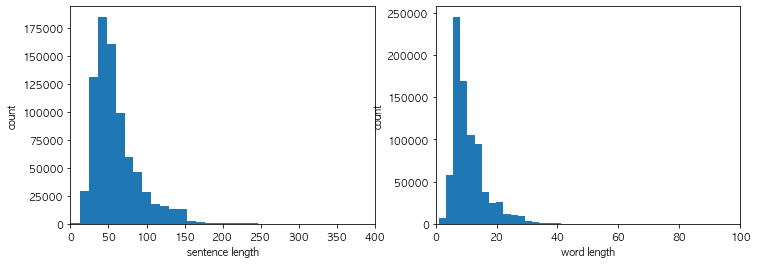

In [6]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (12, 4))

ax1.hist(length, bins = 100)
ax1.set_xlabel('sentence length')
ax1.set_ylabel('count')
ax1.set_xlim(0, 400)

ax2.hist(word_cnt, bins = 100)
ax2.set_xlabel('word length')
ax2.set_ylabel('count')
ax2.set_xlim(0, 100)
plt.show()


### Word Cleaning 

In [7]:
# jay.jay_reg()

In [8]:
import re

def re_norm(i):
    return re.sub('[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》]',"",str(i)).lower()

In [9]:
q1_lst = [re_norm(i) for i in df.question1]
q2_lst = [re_norm(i) for i in df.question2]
q1_lst[:2], q2_lst[:2]

(['what is the step by step guide to invest in share market in india',
  'what is the story of kohinoor kohinoor diamond'],
 ['what is the step by step guide to invest in share market',
  'what would happen if the indian government stole the kohinoor kohinoor diamond back'])

### Tokenizer

In [10]:
# jay.jay_token()

#### Tokenizing

In [11]:
max_feature = 200000
max_len = 31
embedding_dim = 300

In [12]:
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

token = Tokenizer(max_feature)
token.fit_on_texts(q1_lst + q2_lst)
vocab_size = len(token.word_index) + 1
print(vocab_size)

Using TensorFlow backend.


110837


#### text data preprocessing

In [13]:
q1_seq = token.texts_to_sequences(q1_lst)
q2_seq = token.texts_to_sequences(q2_lst)

q1_data = pad_sequences(q1_seq, maxlen = max_len)
q2_data = pad_sequences(q2_seq, maxlen = max_len)
labels = np.array(df.is_duplicate, dtype = int)
print(q1_data.shape, q2_data.shape, labels.shape)

(404290, 31) (404290, 31) (404290,)


In [14]:
data_file = {}
data_file['q1_train'] = q1_data
data_file['q2_train'] = q2_data
data_file['label_train'] = labels

In [15]:
config = {}
config['max_feature'] = max_feature
config['max_len'] = max_len
config['embedding_dim'] = embedding_dim
config['vocab_size'] = vocab_size
config

{'max_feature': 200000,
 'max_len': 31,
 'embedding_dim': 300,
 'vocab_size': 110837}

### Glove
- word embedding
    - 비슷한 단어들을 서로 가깝도록 묶음으로써 하나의 문장이 그와 비슷한 의미를 지닌 문장 클래스로 일반화 될 수 있도록 해준다.
    - 그저 동의어만을 바궈줄 수 있는 것이 아니라, 비슷한 역할을 가지는 단어를 바꿀 수도 있다는 것을 의미한다.
    - 단어 간의 관계가 벡타간의 차이에 녹아 들어감

In [16]:
# jay.jay_glove()

#### processing GloVe Embedding

In [17]:
from os.path import expanduser, exists
from keras.utils.data_utils import get_file
from zipfile import ZipFile


KERAS_DATASETS_DIR = expanduser('~/.keras/datasets/')
GLOVE_ZIP_FILE_URL = 'http://nlp.stanford.edu/data/glove.840B.300d.zip'
GLOVE_ZIP_FILE = 'glove.840B.300d.zip'
GLOVE_FILE = 'glove.840B.300d.txt'

if not exists (KERAS_DATASETS_DIR + GLOVE_ZIP_FILE):
    zipfile = ZipFile(get_file(GLOVE_ZIP_FILE, GLOVE_ZIP_FILE_URL))
    zipfile.extract(GLOVE_FILE, path=KERAS_DATASETS_DIR)

print("processing", GLOVE_FILE)
embd_index = {}
with open(KERAS_DATASETS_DIR + GLOVE_FILE, encoding='utf-8') as file:
    for line in file:
        recods = line.split(' ')
        word = recods[0]
        vec_dim = np.asarray(recods[1:], dtype = 'float32')
        embd_index[word] = vec_dim
print("word embddings:", len(embd_index))

2176770048/2176768927 [==============================] - 1149s 1us/step
processing glove.840B.300d.txt
word embddings: 2196016


In [18]:
config['num_words'] = min(max_feature, len(token.word_index))
config

{'max_feature': 200000,
 'max_len': 31,
 'embedding_dim': 300,
 'vocab_size': 110837,
 'num_words': 110836}

#### Word Embedding Matrix

In [19]:
num_words = min(max_feature, vocab_size)
embedding_matrix = np.zeros((num_words, embedding_dim))

for word, index in token.word_index.items():
    if index > max_feature:
        continue
    embd_vec = embd_index.get(word)
    if embd_vec is not None:
        embedding_matrix[index] = embd_vec
        
print('Null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

Null word embeddings: 41249


In [20]:
data_file['embedding_matrix'] = embedding_matrix
data_file

{'q1_train': array([[    0,     0,     0, ...,   372,     8,    35],
        [    0,     0,     0, ..., 11876, 11876,  4561],
        [    0,     0,     0, ...,   142,     6,  2775],
        ...,
        [    0,     0,     0, ...,     3,    49,  4328],
        [    0,     0,     0, ...,    32,    81,   229],
        [    0,     0,     0, ...,   150,    29,  4650]], dtype=int32),
 'q2_train': array([[    0,     0,     0, ...,     8,   749,   372],
        [    0,     0,     0, ..., 11876,  4561,   199],
        [    0,     0,     0, ...,  1314,   212, 11238],
        ...,
        [    0,     0,     0, ...,    73,    64,  4328],
        [    0,     0,     0, ...,  5022,    12,  6573],
        [    0,     0,     0, ...,    29,    34,  4650]], dtype=int32),
 'label_train': array([0, 0, 0, ..., 0, 0, 0]),
 'embedding_matrix': array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.27204001, -0.06203   , -0.1884    , ...,  0.13015001,


In [21]:
config

{'max_feature': 200000,
 'max_len': 31,
 'embedding_dim': 300,
 'vocab_size': 110837,
 'num_words': 110836}

### Data Split

In [22]:
from sklearn.model_selection import train_test_split

x = np.stack((q1_data, q2_data), axis = 1)
y = labels
x.shape, y.shape

((404290, 2, 31), (404290,))

In [23]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, random_state = 42)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((363861, 2, 31), (40429, 2, 31), (363861,), (40429,))

In [24]:
q1_train = x_train[:,0] #(q1_data)
q2_train = x_train[:,1]
q1_test = x_test[:,0]
q2_test = x_test[:,1]
q1_train.shape, q2_train.shape, q1_test.shape, q2_test.shape

((363861, 31), (363861, 31), (40429, 31), (40429, 31))

### Model

In [25]:
config

{'max_feature': 200000,
 'max_len': 31,
 'embedding_dim': 300,
 'vocab_size': 110837,
 'num_words': 110836}

In [26]:
data_file.keys()

dict_keys(['q1_train', 'q2_train', 'label_train', 'embedding_matrix'])

- **TimeDistributed()**
    - 각 스텝마다 cost를 계산해서 하위 스텝으로 오류를 전파하여 각 weight를 업데이트 해라
    - else: LSTM의 중간 출력이 모두 사용되지만 TimeDistributed()가 사용되지 않으면, 시간축으로 분산되지 않아서 모든 중간 출력에 대해 마지막 스텝에서 cost가 계산되고 마지막 스텝부터 오류가 전파된다
- **BatchNormalization()**
    - Gradient Vanishing 이 일어나지 않도록 하는 아이디어 중 하나
    - ReLU, Initialization, Small Learning Rate 등과 같은 간접적인 방법보다 전체적인 Training 과정 자체를 안정화 하여 학습 속도를 가속시킬 수 있는 근본적인 방법
    - reason: 'Internal Covariance Shift'
        - Network의 각 층이나 Activation 마다 input의 distribution이 달라지는 현상
        - 따라서 이 현상을 막기 위해서 간단하게 각 층의 input의 distribution을 mean = 0 & sd = 1로 normalization
        - whitening으로 input의 feature들을 uncorrelated 하게 만들어주고, 각각의 variance를 1로 만들어 주는 작업
        - 하지만, whitening의 계산과 inverse의 계산은 계산량이 많아 지게 하고, 더구나 whitening으로 parameter들의 영향이 무시 된다는 것
    - algorithm:
        - assume that the features are uncorrelated to each other and normalize the feature under the condition of mean = 0 and var = 1
        - The reason fix the mean and var into 0 and 1 is to remove the non-linearity of the Activation Function since the two outputs of the sigmoid function is more likely a linear
        - While normalized features is computed, scale factor(gamma) and shift factor(beta) are added so that they are trained together on the stage of the Back-propagation
        - Use mean and variance from a mini-batch to be normalized
    - Benefit
        - able to utilize a high learning rate since the parameters are not affected during Propagation; thus, fast learning process
        - has a regulization effect itself and same effect like Dropout, which is a cause for a model to be slow, but BatchNormalization gets rid of the effect at the same time
    - Implementation
        - Deploy a BatchNormalization right before a Hidden layer
        - so that modified input is utilized into an Activation Function

In [27]:
from keras.layers import Input, TimeDistributed, Dense, Lambda, concatenate, Dropout, BatchNormalization
from keras.layers.embeddings import Embedding
from keras.models import Model
from keras import backend as K

q1_input = Input(shape = (max_len, ))
q2_input = Input(shape = (max_len, ))

q1 = Embedding(vocab_size, embedding_dim,
               weights = [embedding_matrix])(q1_input)
q1 = TimeDistributed(Dense(embedding_dim, activation = 'relu'))(q1)
q1 = Lambda(lambda x: K.max(x, axis = 1), output_shape = (embedding_dim, ))(q1)

q2 = Embedding(vocab_size, embedding_dim,
               weights = [embedding_matrix])(q2_input)
q2 = TimeDistributed(Dense(embedding_dim, activation = 'relu'))(q2)
q2 = Lambda(lambda x: K.max(x, axis = 1), output_shape = (embedding_dim, ))(q2)

merged = concatenate([q1, q2])

merged = Dense(200, activation = 'relu')(merged)
merged = Dropout(0.5)(merged)
merged = BatchNormalization()(merged)

merged = Dense(200, activation = 'relu')(merged)
merged = Dropout(0.5)(merged)
merged = BatchNormalization()(merged)

merged = Dense(200, activation = 'relu')(merged)
merged = Dropout(0.5)(merged)
merged = BatchNormalization()(merged)

sigmoid = Dense(1, activation = 'sigmoid')(merged)

model = Model(inputs = [q1_input, q2_input], outputs = sigmoid)
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 31)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 31)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 31, 300)      33251100    input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 31, 300)      33251100    input_2[0][0]                   

In [28]:
from keras.callbacks import EarlyStopping
# early_stopping = EarlyStopping()
history = model.fit([q1_train, q2_train], y_train,
                    epochs = 20, validation_split = 0.2,
                    batch_size = 256)


Train on 291088 samples, validate on 72773 samples
Epoch 1/20
291088/291088 [==============================] - 1109s 4ms/step - loss: 0.5560 - accuracy: 0.7150 - val_loss: 0.4918 - val_accuracy: 0.7640
Epoch 2/20
291088/291088 [==============================] - 1100s 4ms/step - loss: 0.4390 - accuracy: 0.7927 - val_loss: 0.4616 - val_accuracy: 0.7820
Epoch 3/20
291088/291088 [==============================] - 1099s 4ms/step - loss: 0.3669 - accuracy: 0.8329 - val_loss: 0.4662 - val_accuracy: 0.7739
Epoch 4/20
291088/291088 [==============================] - 1100s 4ms/step - loss: 0.3103 - accuracy: 0.8609 - val_loss: 0.4704 - val_accuracy: 0.7829
Epoch 5/20
291088/291088 [==============================] - 1099s 4ms/step - loss: 0.2632 - accuracy: 0.8845 - val_loss: 0.4912 - val_accuracy: 0.7912
Epoch 6/20
291088/291088 [==============================] - 1098s 4ms/step - loss: 0.2242 - accuracy: 0.9040 - val_loss: 0.4896 - val_accuracy: 0.7947
Epoch 7/20
291088/291088 [================

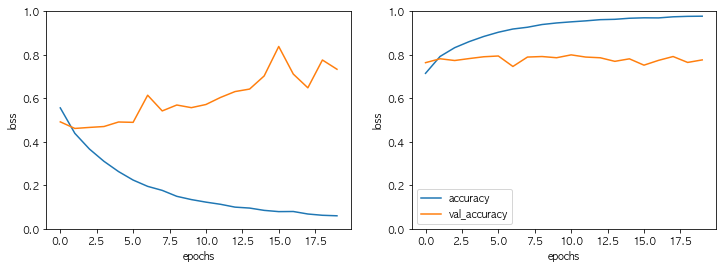

In [29]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize =(12,4))
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
ax1.set_ylim(0,1)
plt.legend(['train_loss', 'val_loss'])

ax2.plot(history.history['accuracy'])
ax2.plot(history.history['val_accuracy'])
ax2.set_xlabel('epochs')
ax2.set_ylabel('loss')
ax2.set_ylim(0,1)
plt.legend(['accuracy', 'val_accuracy'])
plt.show()